# Modelling (AIC)

## 1. Import Libraries

In [102]:
# Import Libraries


# import os
# os.environ['USE_PYGEOS'] = '0'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
from geopandas import GeoDataFrame
import statsmodels.api as sm
from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from pysal.model import spreg
from splot.esda import moran_scatterplot
import seaborn as sns
import statsmodels
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
from typing import Type
import sweetviz as sv

import plotly.io as pio
pio.renderers.default='notebook'

In [103]:
# path definition for each user - please edit to add new users
path_pb = "C:/Users/pauloricardolb/OneDrive - Universidade de Aveiro/TRABALHO_PROJETOS/AP01_ONGOING/POAT/SHARED_Andre"
path_al = "/Users/andresilvalima/Library/CloudStorage/OneDrive-UniversidadedeAveiro/SHARED_Andre"

In [104]:
# path definition
path = path_al

## 2. Data Preparation for Modelling

### 2.1 Loading and Transforming Datasets

In [105]:
all_data = pd.read_pickle("02_Pickles/all_data.piclo")

In [106]:
# add 1 to AL_pc in order to avoid 0 values
all_data['AL_pc_temp']=all_data['AL_pc']+1

In [107]:
# log transformation of AL_pc
all_data['Log_AL'] = np.log(all_data['AL_pc_temp'])

In [108]:
# drop unnecessary columns
all_data.drop(columns=['AL_pc_temp'], axis=1,inplace=True)

In [109]:
# log transformation of Typology
all_data['Log_Typ'] = np.log(all_data['Typology'])

In [110]:
all_data['Log_AL'].describe()

count    9018.000000
mean        0.026179
std         0.096603
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.997924
Name: Log_AL, dtype: float64

In [111]:
all_data['Log_Typ'].describe()

count      9018.0
mean     1.209507
std       0.33387
min           0.0
25%      1.098612
50%      1.098612
75%      1.386294
max       1.94591
Name: Log_Typ, dtype: Float64

In [112]:
all_data.head()

Nature  Typology  Status     Price   Log_P_A      A  Year  Cluster_new   
0       2         5       1  224500.0  6.463698  350.0  2008            9  \
1       1         4       3  137000.0  6.851002  145.0  2008           45   
2       1         3       1  193000.0  6.966439  182.0  2008           19   
3       2         5       4  374000.0  6.840547  400.0  2008           48   
4       1         2       1   91500.0  7.080289   77.0  2008           19   

   NrUtentes  AL_pc  T  Log_AL   Log_Typ  
0        0.0    0.0  0     0.0  1.609438  
1        0.0    0.0  0     0.0  1.386294  
2        0.0    0.0  0     0.0  1.098612  
3        0.0    0.0  0     0.0  1.609438  
4        0.0    0.0  0     0.0  0.693147

In [113]:
all_data.shape

(9018, 13)

In [114]:
all_data['T'].value_counts()

T
0    7241
1    1777
Name: count, dtype: int64

### 2.2 Bring New Cluster Labels to the main datasets

In [115]:
clusters = pd.read_pickle("02_Pickles/piclo_clusters_2.piclo")

In [116]:
clusters.head()

Cluster_new                                           geometry      area   
0            1  POLYGON ((-43858.268 105485.133, -43926.607 10...  0.036101  \
1            2  POLYGON ((-41894.818 101023.152, -41985.704 10...  0.023841   
2            3  POLYGON ((-43381.069 106148.686, -43381.861 10...  0.024286   
3            4  POLYGON ((-42925.331 103598.712, -42932.138 10...  0.142291   
4            5  POLYGON ((-42665.937 104985.157, -42696.042 10...  0.141979   

    PCA_h_1   PCA_h_2   PCA_h_3   PCA_h_4   PCA_h_5   PCA_h_6   PCA_h_7  ...   
0 -1.089350 -0.220396  0.327666  0.486717  0.093667  1.268302  0.401024  ...  \
1 -1.908428  0.098360 -0.043268 -0.013403 -0.705910  0.229802  0.116456  ...   
2  4.071759 -2.631850 -2.454731 -1.402054  0.647511 -1.903904 -0.304025  ...   
3 -1.847645  0.076802  0.727929  0.323953  0.126725  0.193189  0.124968  ...   
4  0.058212  0.421190  0.915971 -0.866360 -1.606856  0.028771  0.010300  ...   

    PCA_p_8   PCA_p_9  PCA_p_10  Zona_Ward  Zona_Ward_Queen  tot_cs  tot_py   
0 -1.098153  0.121210 -0.405767          4                2   154.0     NaN  \
1 -0.600227  1.142661  0.163015          4                2   119.0     6.0   
2  1.163779  0.507817 -0.045294          4                2    67.0     4.0   
3 -0.855227  0.092341 -0.182643          4                2   118.0    32.0   
4  0.357132  0.053136  0.064562          4                2   146.0    34.0   

   tot_min  Zona_Maxp  Zona_SKATER  
0    154.0          1            0  
1      6.0          7            1  
2      4.0          2            2  
3     32.0          1            0  
4     34.0          2            2  

[5 rows x 31 columns]

In [117]:
# merge dwelling data with clusters data
all_data=all_data.merge(clusters, on='Cluster_new', how='left')

In [118]:
all_data.columns

Index(['Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4',
       'PCA_h_5', 'PCA_h_6', 'PCA_h_7', 'PCA_h_8', 'PCA_h_9', 'PCA_h_10',
       'PCA_h_11', 'PCA_p_1', 'PCA_p_2', 'PCA_p_3', 'PCA_p_4', 'PCA_p_5',
       'PCA_p_6', 'PCA_p_7', 'PCA_p_8', 'PCA_p_9', 'PCA_p_10', 'Zona_Ward',
       'Zona_Ward_Queen', 'tot_cs', 'tot_py', 'tot_min', 'Zona_Maxp',
       'Zona_SKATER'],
      dtype='object')

In [119]:
# drop unnecessary columns
all_data.drop(columns=['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 
                          'PCA_h_4', 'PCA_h_5', 'PCA_h_6','PCA_h_7', 'PCA_h_8', 
                          'PCA_h_9', 'PCA_h_10', 'PCA_h_11',
                          'PCA_p_1', 'PCA_p_2', 'PCA_p_3', 'PCA_p_4', 'PCA_p_5', 
                          'PCA_p_6','PCA_p_7', 'PCA_p_8', 'PCA_p_9', 'PCA_p_10',
                          'tot_cs', 'tot_py', 'tot_min'], axis=1,inplace=True)

In [120]:
# drop dwellings with no lat lon information (geometry)
all_data=all_data[~all_data['geometry'].isna()]

In [121]:
all_data.columns

Index(['Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen', 'Zona_Maxp',
       'Zona_SKATER'],
      dtype='object')

In [122]:
# from the initial 123 clusters, we have now 109 clusters with at least one house from casasapo and primeyield
len(all_data['Cluster_new'].unique())

117

In [123]:
all_data.dtypes

Nature                Int64
Typology              Int64
Status                Int64
Price               float64
Log_P_A             float64
A                   float64
Year                 object
Cluster_new           Int64
NrUtentes           float64
AL_pc               float64
T                     int64
Log_AL              float64
Log_Typ             Float64
geometry           geometry
area                float64
Zona_Ward           float64
Zona_Ward_Queen     float64
Zona_Maxp           float64
Zona_SKATER         float64
dtype: object

In [124]:
all_data['Year'].value_counts()

Year
2010    2239
2008    1861
2009    1491
2007    1284
2018     769
2020     347
2021     326
2006     261
2022     247
2019      72
2005      28
2023      15
Name: count, dtype: int64

In [125]:
# convertion of data to float
all_data['Zona_Ward']=np.floor(pd.to_numeric(all_data['Zona_Ward'], errors='coerce')).astype('float64')
all_data['Zona_Ward_Queen']=np.floor(pd.to_numeric(all_data['Zona_Ward_Queen'], errors='coerce')).astype('float64')
all_data['Zona_Maxp']=np.floor(pd.to_numeric(all_data['Zona_Maxp'], errors='coerce')).astype('float64')
all_data['Zona_SKATER']=np.floor(pd.to_numeric(all_data['Zona_SKATER'], errors='coerce')).astype('float64')
all_data['Cluster_new']=np.floor(pd.to_numeric(all_data['Cluster_new'], errors='coerce')).astype('float64')
all_data['Year']=np.floor(pd.to_numeric(all_data['Year'], errors='coerce')).astype('float64')
all_data['Nature']=np.floor(pd.to_numeric(all_data['Nature'], errors='coerce')).astype('float64')
all_data['Typology']=np.floor(pd.to_numeric(all_data['Typology'], errors='coerce')).astype('float64')
all_data['Status']=np.floor(pd.to_numeric(all_data['Status'], errors='coerce')).astype('float64')
all_data['T']=np.floor(pd.to_numeric(all_data['T'], errors='coerce')).astype('float64')

In [126]:
all_data.dtypes

Nature              float64
Typology            float64
Status              float64
Price               float64
Log_P_A             float64
A                   float64
Year                float64
Cluster_new         float64
NrUtentes           float64
AL_pc               float64
T                   float64
Log_AL              float64
Log_Typ             Float64
geometry           geometry
area                float64
Zona_Ward           float64
Zona_Ward_Queen     float64
Zona_Maxp           float64
Zona_SKATER         float64
dtype: object

In [127]:
all_data.columns

Index(['Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen', 'Zona_Maxp',
       'Zona_SKATER'],
      dtype='object')

### 2.3 Generate Discriptive Statistics HTML

In [128]:
# este relatório foi gerado utilizando o sweetviz com o pandas 1.5.3
# para instalar versão 1.5.3, utilizar o anaconda (pip install --upgrade pandas==1.5)
# depois deverá ser atualizado o pandas para a ultima versão (pip install --upgrade pandas)

# my_report = sv.analyze(all_data[['Nature', 'Typology', 'Status', 'Price', 'A', 'Year','AL_pc', 'T']])
# my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

## 3. Linear Regressions (Aveiro)

### 3.1 Data Preparation for DID Linear Regression

In [129]:
# copy data
spatial_data=all_data.copy()

In [130]:
plot_spatial_data=spatial_data.copy()

In [131]:
# transform data to geodataframe
plot_spatial_data=GeoDataFrame(plot_spatial_data, geometry='geometry')

In [132]:
plot_spatial_data.columns

Index(['Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen', 'Zona_Maxp',
       'Zona_SKATER'],
      dtype='object')

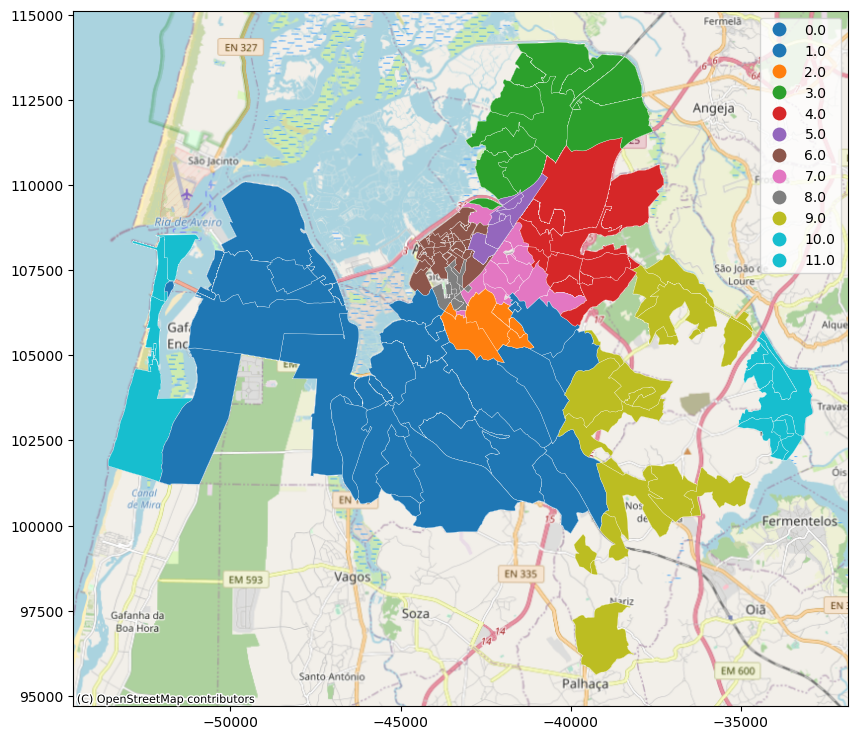

In [133]:
# view Zona_SKATER clusters
ax=plot_spatial_data.plot(figsize=(10, 10), column="Zona_SKATER", categorical=True, edgecolor="w", legend=True, linewidth=0.2,cmap='tab10')
cx.add_basemap(ax,crs=plot_spatial_data.crs,source=cx.providers.OpenStreetMap.Mapnik)


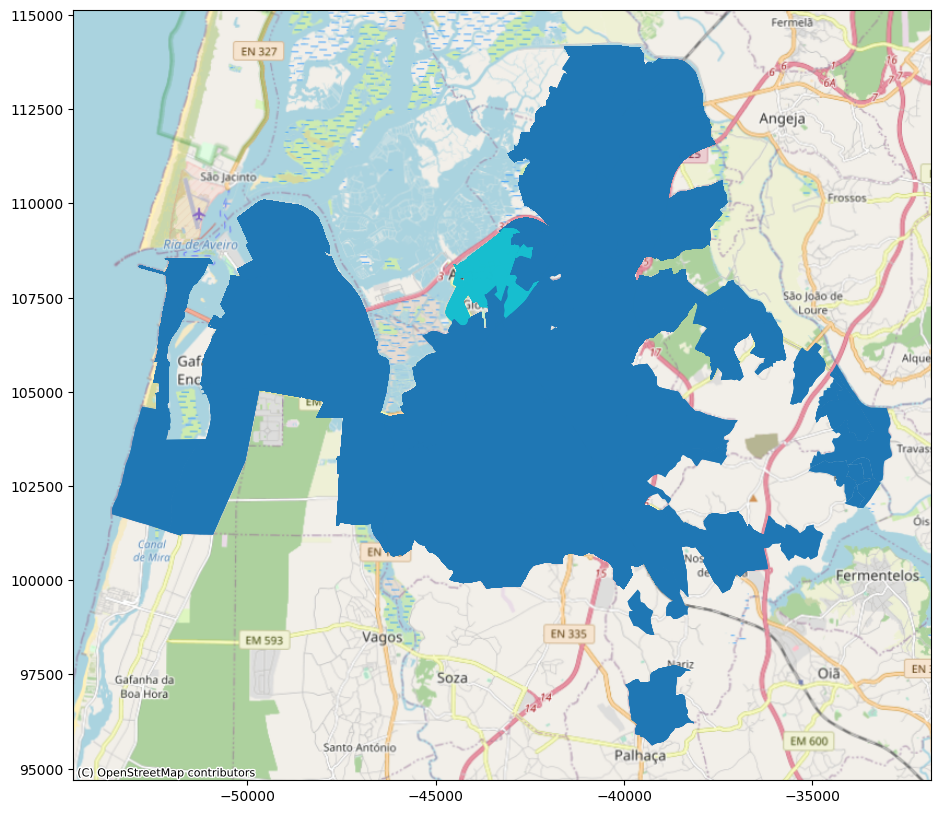

In [134]:
# view cluster of interest - Aveiro vity center
ax=plot_spatial_data.plot(plot_spatial_data['Zona_SKATER']==6.0,figsize=(20,10))
cx.add_basemap(ax,crs=plot_spatial_data.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [135]:
plot_spatial_data.head()

Nature  Typology  Status     Price   Log_P_A      A    Year  Cluster_new   
0     2.0       5.0     1.0  224500.0  6.463698  350.0  2008.0          9.0  \
1     1.0       4.0     3.0  137000.0  6.851002  145.0  2008.0         45.0   
2     1.0       3.0     1.0  193000.0  6.966439  182.0  2008.0         19.0   
3     2.0       5.0     4.0  374000.0  6.840547  400.0  2008.0         48.0   
4     1.0       2.0     1.0   91500.0  7.080289   77.0  2008.0         19.0   

   NrUtentes  AL_pc    T  Log_AL   Log_Typ   
0        0.0    0.0  0.0     0.0  1.609438  \
1        0.0    0.0  0.0     0.0  1.386294   
2        0.0    0.0  0.0     0.0  1.098612   
3        0.0    0.0  0.0     0.0  1.609438   
4        0.0    0.0  0.0     0.0  0.693147   

                                            geometry      area  Zona_Ward   
0  POLYGON ((-38979.844 107301.719, -39032.071 10...  0.127582        4.0  \
1  POLYGON ((-42807.987 107844.848, -42845.316 10...  0.048703        9.0   
2  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
3  POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660        1.0   
4  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   

   Zona_Ward_Queen  Zona_Maxp  Zona_SKATER  
0              4.0        5.0          4.0  
1              2.0        2.0          5.0  
2              3.0        4.0          6.0  
3              1.0        1.0          1.0  
4              3.0        4.0          6.0

In [136]:
# filter data for Aveiro city center
data_aveiro=spatial_data[spatial_data['Zona_SKATER']==6.0]

In [137]:
# transform data to geodataframe
data_aveiro=GeoDataFrame(data_aveiro, geometry='geometry')

In [138]:
data_aveiro.reset_index(drop=True, inplace=True)

In [139]:
data_aveiro.head()

Nature  Typology  Status     Price   Log_P_A      A    Year  Cluster_new   
0     1.0       3.0     1.0  193000.0  6.966439  182.0  2008.0         19.0  \
1     1.0       2.0     1.0   91500.0  7.080289   77.0  2008.0         19.0   
2     1.0       2.0     1.0   94000.0  7.020233   84.0  2008.0         19.0   
3     1.0       4.0     1.0  168100.0  6.957141  160.0  2008.0         19.0   
4     1.0       2.0     1.0  100000.0  6.969631   94.0  2008.0         19.0   

   NrUtentes  AL_pc    T  Log_AL   Log_Typ   
0        0.0    0.0  0.0     0.0  1.098612  \
1        0.0    0.0  0.0     0.0  0.693147   
2        0.0    0.0  0.0     0.0  0.693147   
3        0.0    0.0  0.0     0.0  1.386294   
4        0.0    0.0  0.0     0.0  0.693147   

                                            geometry      area  Zona_Ward   
0  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0  \
1  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
2  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
3  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   
4  POLYGON ((-43051.492 108661.656, -43052.174 10...  0.010973        8.0   

   Zona_Ward_Queen  Zona_Maxp  Zona_SKATER  
0              3.0        4.0          6.0  
1              3.0        4.0          6.0  
2              3.0        4.0          6.0  
3              3.0        4.0          6.0  
4              3.0        4.0          6.0

In [140]:
# check no. of dwellings per cluster in Aveiro Center
pd.pivot_table(data_aveiro, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))
# não incluir cluster 80, 102 e 106, por escassez de dados

Log_P_A
Cluster_new         
19.0             414
22.0               5
26.0              60
28.0               4
31.0             207
40.0              63
41.0              95
42.0              44
43.0              29
57.0              27
80.0               2
101.0             31
102.0              1
103.0             30
105.0             65
106.0              1
107.0             43
109.0             30
111.0              9

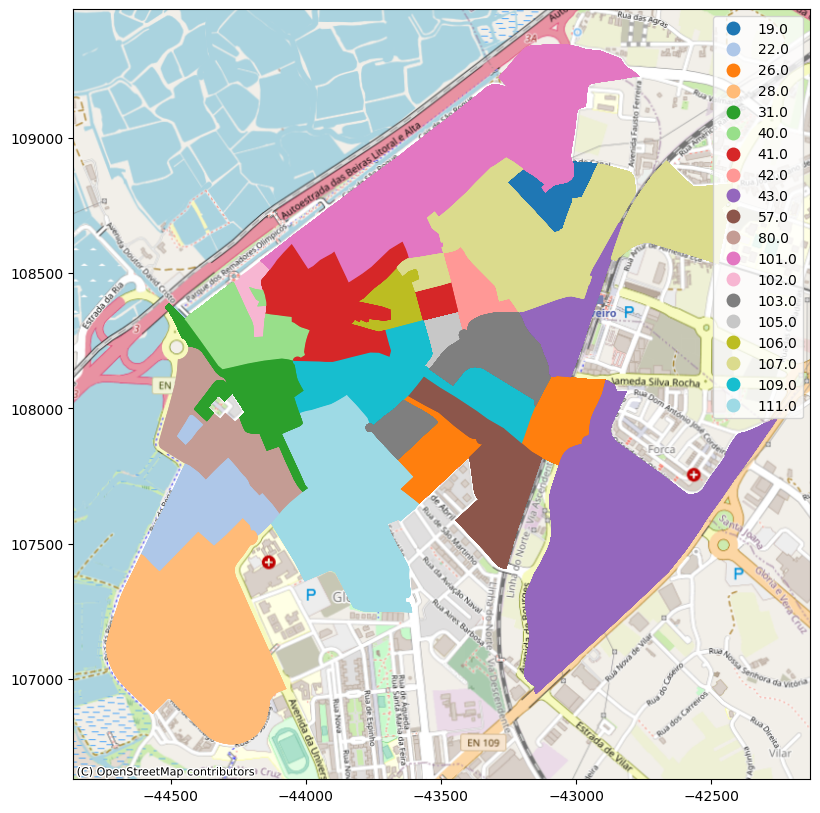

In [141]:
# view clusters in Aveiro city center
ax=data_aveiro.plot(column=data_aveiro['Cluster_new'],categorical=True, legend=True, figsize=(10,10), cmap='tab20')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [142]:
# Area de Intervenção, a ser considerada D = 1
lista_D1=[19,40,41,42,101,102,103,105,106,107,109]

In [143]:
# apply above list to data
data_aveiro['D']=np.where(data_aveiro['Cluster_new'].isin(lista_D1), 1, 0)

In [144]:
data_aveiro['D'].value_counts()

D
1    1304
0     448
Name: count, dtype: int64

In [145]:
sum(data_aveiro['D'].value_counts())

1752

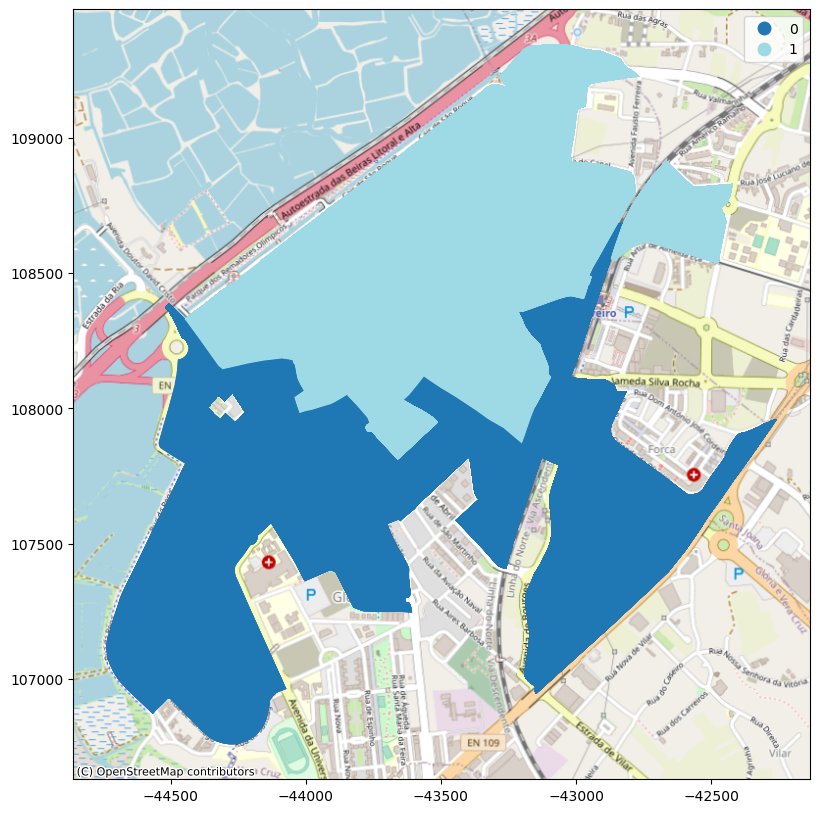

In [146]:
# check areas defined as control and intervention areas (D=0 and D=1)
ax=data_aveiro.plot(column=data_aveiro['D'],categorical=True, legend=True, figsize=(10,10), cmap='tab20')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [147]:
# calculate DT (true when both D and T are equal to 1)
data_aveiro['DT']=data_aveiro['D']*data_aveiro['T']

In [148]:
# valores do Indice de Preços da Habitação para Aveiro (valores para 21, 22 e 23 são previsões, com base na tendência dos últimos anos)
IPI2005=116.5
IPI2006=110.9
IPI2007=114.3
IPI2008=109.4
IPI2009=103.1
IPI2010=104.4
IPI2018=100.8
IPI2019=114.2
IPI2020=126.2
IPI2021=131.9
IPI2022=133.3
IPI2023=134.6

In [149]:
# write IPI values to new column
def new_column_value(Year):
    if Year == 2005.0:
        return IPI2005
    elif Year == 2006.0:
        return IPI2006
    elif Year == 2007.0:
        return IPI2007
    elif Year == 2008.0:
        return IPI2008
    elif Year == 2009.0:
        return IPI2009
    elif Year == 2010.0:
        return IPI2010
    elif Year == 2018.0:
        return IPI2018
    elif Year == 2019.0:
        return IPI2019
    elif Year == 2020.0:
        return IPI2020
    elif Year == 2021.0:
        return IPI2021
    elif Year == 2022.0:
        return IPI2022
    elif Year == 2023.0:
        return IPI2023


data_aveiro["IPI"] = data_aveiro["Year"].apply(new_column_value)

In [150]:
# calculate log of IPI
data_aveiro["Log_IPI"]=np.log(data_aveiro['IPI'])

In [151]:
# calculate log of Typology
data_aveiro['Log_Typ']=np.log(data_aveiro['Typology'])

In [152]:
# get dummies
linreg_center = pd.get_dummies(data_aveiro, columns=['Status','Cluster_new'], drop_first=True, dtype=float)

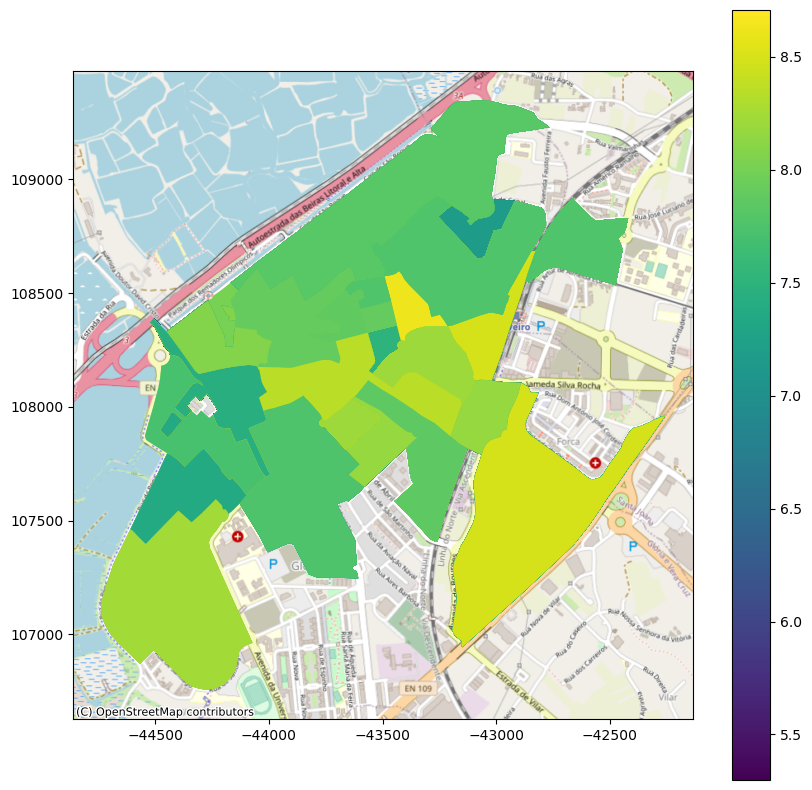

In [153]:
# check log_P_A distribution in the territory
ax=data_aveiro.plot(column=data_aveiro['Log_P_A'], legend=True, figsize=(10,10), cmap='viridis')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

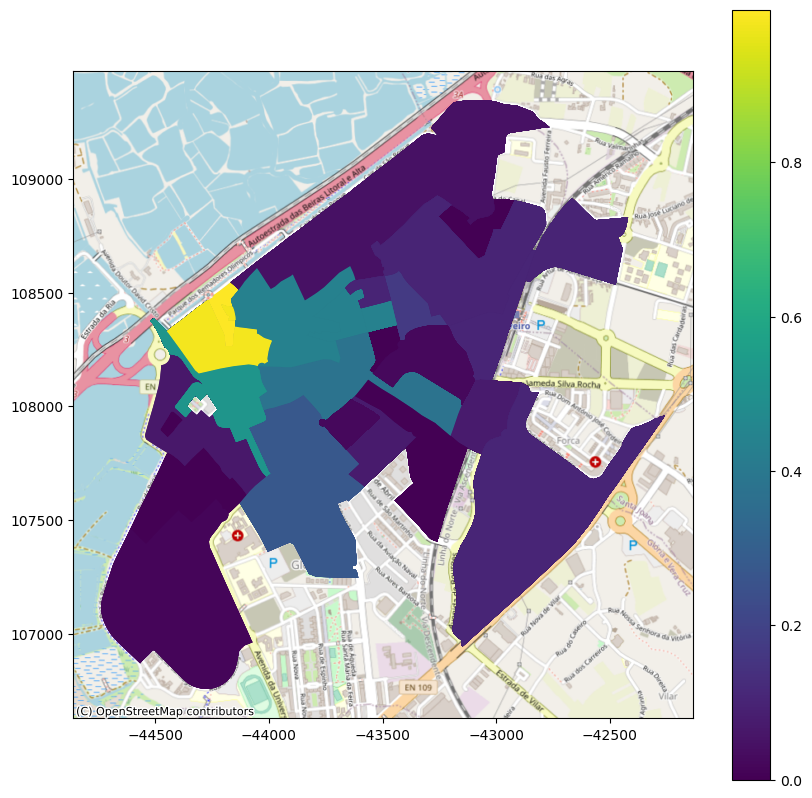

In [154]:
# check log_AL distribution in the territory
ax=data_aveiro.plot(column=data_aveiro['Log_AL'], legend=True, figsize=(10,10), cmap='viridis')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

### 3.2 Linear Regression (focused in Aveiro Center - SKATER Cluster)

In [155]:
linreg_center.columns

Index(['Nature', 'Typology', 'Price', 'Log_P_A', 'A', 'Year', 'NrUtentes',
       'AL_pc', 'T', 'Log_AL', 'Log_Typ', 'geometry', 'area', 'Zona_Ward',
       'Zona_Ward_Queen', 'Zona_Maxp', 'Zona_SKATER', 'D', 'DT', 'IPI',
       'Log_IPI', 'Status_2.0', 'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Cluster_new_22.0', 'Cluster_new_26.0', 'Cluster_new_28.0',
       'Cluster_new_31.0', 'Cluster_new_40.0', 'Cluster_new_41.0',
       'Cluster_new_42.0', 'Cluster_new_43.0', 'Cluster_new_57.0',
       'Cluster_new_80.0', 'Cluster_new_101.0', 'Cluster_new_102.0',
       'Cluster_new_103.0', 'Cluster_new_105.0', 'Cluster_new_106.0',
       'Cluster_new_107.0', 'Cluster_new_109.0', 'Cluster_new_111.0'],
      dtype='object')

In [156]:
# check number of dwellings per cluster
pd.pivot_table(data_aveiro, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))

Log_P_A
Cluster_new         
19.0             414
22.0               5
26.0              60
28.0               4
31.0             207
40.0              63
41.0              95
42.0              44
43.0              29
57.0              27
80.0               2
101.0             31
102.0              1
103.0             30
105.0             65
106.0              1
107.0             43
109.0             30
111.0              9

In [157]:
# define X and y
c_y_eur_area  = linreg_center['Log_P_A'].astype(float)

c_X_eur_area = linreg_center[['Log_AL',
       'Log_Typ', 'D', 'DT','T', 'Log_IPI', 'Status_2.0',
       'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Cluster_new_22.0', 'Cluster_new_26.0',
       'Cluster_new_28.0', 'Cluster_new_40.0',
       'Cluster_new_41.0', 'Cluster_new_42.0', 'Cluster_new_43.0',
       'Cluster_new_57.0', 'Cluster_new_80.0', 'Cluster_new_101.0',
       'Cluster_new_103.0', 'Cluster_new_105.0',
       'Cluster_new_107.0', 'Cluster_new_109.0',
       'Cluster_new_111.0']].astype(float)
# apenas 1 caso - 'Cluster_new_106.0','Cluster_new_102.0'
# removido Cluster_new_31.0, VIF muito alto

In [158]:
# check VIF
vif_data = pd.DataFrame()
vif_data["feature"] = c_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(c_X_eur_area.values, i)
                          for i in range(len(c_X_eur_area.columns))]

print(vif_data)

              feature        VIF
0              Log_AL  14.384651
1             Log_Typ  11.581043
2                   D  18.264836
3                  DT   7.512249
4                   T  17.114083
5             Log_IPI  26.475762
6          Status_2.0   1.823022
7          Status_3.0   2.113377
8          Status_4.0   1.470787
9          Status_5.0   2.408238
10   Cluster_new_22.0   1.095316
11   Cluster_new_26.0   1.961054
12   Cluster_new_28.0   1.120804
13   Cluster_new_40.0   2.996596
14   Cluster_new_41.0   1.554392
15   Cluster_new_42.0   1.285276
16   Cluster_new_43.0   1.502989
17   Cluster_new_57.0   1.773707
18   Cluster_new_80.0   1.098793
19  Cluster_new_101.0   2.442360
20  Cluster_new_103.0   2.583476
21  Cluster_new_105.0   1.470941
22  Cluster_new_107.0   2.692742
23  Cluster_new_109.0   1.702195
24  Cluster_new_111.0   1.112565


In [159]:
# linear model for casasapo with log of price per square meter as dependent variable
c_X_eur_area = sm.add_constant(c_X_eur_area)
model_c_eur_area = sm.OLS(c_y_eur_area, c_X_eur_area)
results_c_eur_area = model_c_eur_area.fit()
results_c_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.559    
Dependent Variable: Log_P_A          AIC:                42.4342  
Date:               2023-05-22 11:41 BIC:                184.6156 
No. Observations:   1752             Log-Likelihood:     4.7829   
Df Model:           25               F-statistic:        89.65    
Df Residuals:       1726             Prob (F-statistic): 7.78e-290
R-squared:          0.565            Scale:              0.059108 
------------------------------------------------------------------
                   Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
const              1.5425   0.4760   3.2407 0.0012  0.6089  2.4760
Log_AL            -1.0906   0.1072 -10.1744 0.0000 -1.3009 -0.8804
Log_Typ           -0.1300   0.0168  -7.7195 0.0000 -0.1630 -0.0970
D                 -0.0728   0.0288  -2.5290 0.0115 -0.1293 -0.0163
DT                 0.4463   0.0454   9.8338 0.0000  0.3573  0.5353
T                  0.5134   0.0477  10.7630 0.0000  0.4198  0.6069
Log_IPI            1.2616   0.1021  12.3611 0.0000  1.0614  1.4617
Status_2.0        -0.0626   0.0185  -3.3769 0.0007 -0.0989 -0.0262
Status_3.0        -0.1721   0.0167 -10.3293 0.0000 -0.2048 -0.1394
Status_4.0        -0.3444   0.0299 -11.5015 0.0000 -0.4032 -0.2857
Status_5.0        -0.0186   0.0192  -0.9699 0.3322 -0.0563  0.0191
Cluster_new_22.0  -0.0385   0.1140  -0.3375 0.7358 -0.2621  0.1851
Cluster_new_26.0   0.0241   0.0370   0.6521 0.5144 -0.0484  0.0966
Cluster_new_28.0   0.1720   0.1155   1.4897 0.1365 -0.0545  0.3985
Cluster_new_40.0   0.5271   0.0423  12.4572 0.0000  0.4441  0.6101
Cluster_new_41.0   0.1686   0.0283   5.9656 0.0000  0.1132  0.2241
Cluster_new_42.0  -0.0224   0.0399  -0.5619 0.5742 -0.1006  0.0558
Cluster_new_43.0  -0.0246   0.0480  -0.5129 0.6081 -0.1186  0.0695
Cluster_new_57.0  -0.0083   0.0564  -0.1469 0.8832 -0.1188  0.1023
Cluster_new_80.0   0.3918   0.1809   2.1658 0.0305  0.0370  0.7465
Cluster_new_101.0 -0.4666   0.0604  -7.7286 0.0000 -0.5851 -0.3482
Cluster_new_103.0 -0.2908   0.0640  -4.5423 0.0000 -0.4164 -0.1653
Cluster_new_105.0  0.1148   0.0296   3.8822 0.0001  0.0568  0.1729
Cluster_new_107.0 -0.4491   0.0539  -8.3389 0.0000 -0.5548 -0.3435
Cluster_new_109.0  0.0994   0.0552   1.8009 0.0719 -0.0089  0.2078
Cluster_new_111.0  0.0653   0.0811   0.8050 0.4209 -0.0938  0.2243
------------------------------------------------------------------
Omnibus:              304.904      Durbin-Watson:         1.675   
Prob(Omnibus):        0.000        Jarque-Bera (JB):      3025.968
Skew:                 -0.503       Prob(JB):              0.000   
Kurtosis:             9.359        Condition No.:         420     
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

#### 3.1.a - Diagnostic plots
https://www.statsmodels.org/dev/examples/notebooks/generated/linear_regression_diagnostics_plots.html

In [160]:
# base code for diagnostic plots

style_talk = 'seaborn-talk'    #refer to plt.style.available

class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Author:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

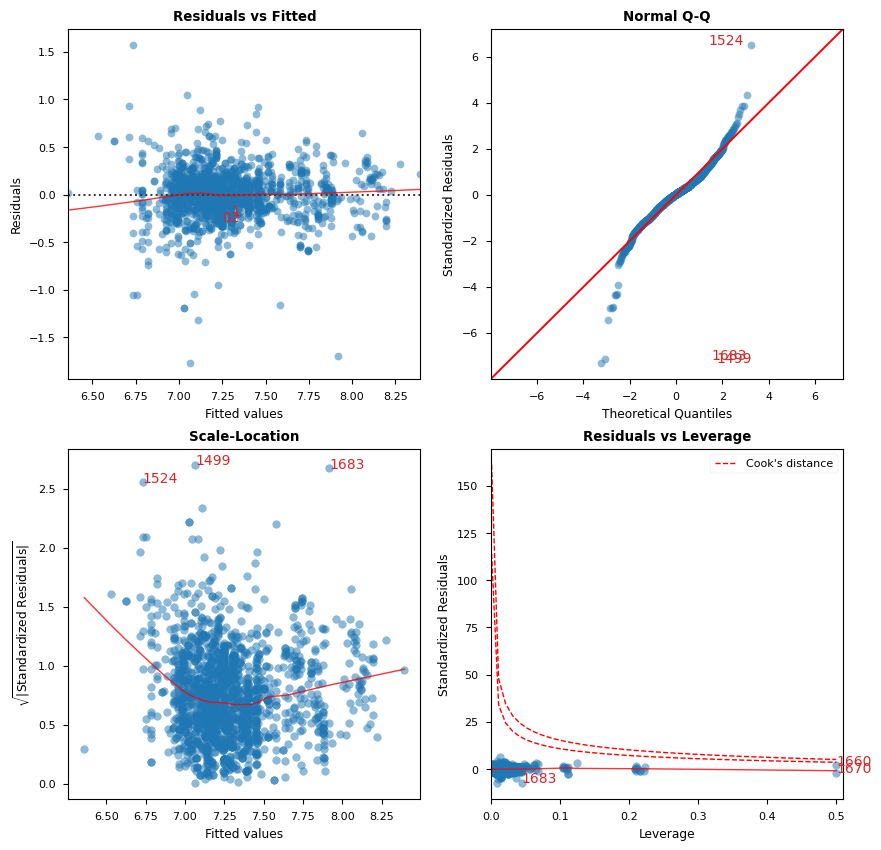

             Features  VIF Factor
11   Cluster_new_22.0        1.10
19   Cluster_new_80.0        1.11
25  Cluster_new_111.0        1.11
13   Cluster_new_28.0        1.12
16   Cluster_new_42.0        1.28
2             Log_Typ        1.30
9          Status_4.0        1.39
22  Cluster_new_105.0        1.42
15   Cluster_new_41.0        1.45
17   Cluster_new_43.0        1.48
7          Status_2.0        1.50
6             Log_IPI        1.56
8          Status_3.0        1.57
24  Cluster_new_109.0        1.67
18   Cluster_new_57.0        1.74
12   Cluster_new_26.0        1.87
10         Status_5.0        1.88
20  Cluster_new_101.0        2.41
21  Cluster_new_103.0        2.58
23  Cluster_new_107.0        2.61
14   Cluster_new_40.0        2.86
3                   D        4.67
4                  DT        6.62
1              Log_AL       11.31
5                   T       12.91
0               const     6715.05


In [161]:
# plot diagnostics for the model
cls = Linear_Reg_Diagnostic(results_c_eur_area)
fig, ax = cls()
fig.savefig('01_Pictures/results_c_eur_area_tests.png')

#### 3.1.c - Difference in Difference validation

In [162]:
data_aveiro.columns

Index(['Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen', 'Zona_Maxp',
       'Zona_SKATER', 'D', 'DT', 'IPI', 'Log_IPI'],
      dtype='object')

In [163]:
# copy data for the model (DID validation)
data_aveiro_DID=data_aveiro.copy()

In [164]:
data_aveiro_DID['Year'].unique()

array([2008., 2005., 2006., 2007., 2009., 2010., 2018., 2019., 2020.,
       2021., 2022., 2023.])

In [165]:
# define D=1 and D=0
for i in data_aveiro_DID['Year'].unique():
    data_aveiro_DID['Year'+str(i)]=np.where(data_aveiro_DID['Year']==i, data_aveiro_DID['D'],0)

In [166]:
data_aveiro_DID

Nature  Typology  Status     Price   Log_P_A      A    Year   
0        1.0       3.0     1.0  193000.0  6.966439  182.0  2008.0  \
1        1.0       2.0     1.0   91500.0  7.080289   77.0  2008.0   
2        1.0       2.0     1.0   94000.0  7.020233   84.0  2008.0   
3        1.0       4.0     1.0  168100.0  6.957141  160.0  2008.0   
4        1.0       2.0     1.0  100000.0  6.969631   94.0  2008.0   
...      ...       ...     ...       ...       ...    ...     ...   
1747     1.0       4.0     1.0  530435.0  8.291104  133.0  2023.0   
1748     1.0       3.0     1.0  375000.0  8.357344   88.0  2023.0   
1749     1.0       4.0     1.0  520435.0  8.272071  133.0  2023.0   
1750     1.0       4.0     1.0  517935.0  8.267256  133.0  2023.0   
1751     1.0       3.0     1.0  323400.0  8.209308   88.0  2023.0   

      Cluster_new  NrUtentes     AL_pc  ...  Year2006.0  Year2007.0   
0            19.0        0.0  0.000000  ...           0           0  \
1            19.0        0.0  0.000000  ...           0           0   
2            19.0        0.0  0.000000  ...           0           0   
3            19.0        0.0  0.000000  ...           0           0   
4            19.0        0.0  0.000000  ...           0           0   
...           ...        ...       ...  ...         ...         ...   
1747        103.0       25.0  0.023234  ...           0           0   
1748        103.0       25.0  0.023234  ...           0           0   
1749        103.0       25.0  0.023234  ...           0           0   
1750        103.0       25.0  0.023234  ...           0           0   
1751        103.0       25.0  0.023234  ...           0           0   

      Year2009.0 Year2010.0  Year2018.0  Year2019.0  Year2020.0  Year2021.0   
0              0          0           0           0           0           0  \
1              0          0           0           0           0           0   
2              0          0           0           0           0           0   
3              0          0           0           0           0           0   
4              0          0           0           0           0           0   
...          ...        ...         ...         ...         ...         ...   
1747           0          0           0           0           0           0   
1748           0          0           0           0           0           0   
1749           0          0           0           0           0           0   
1750           0          0           0           0           0           0   
1751           0          0           0           0           0           0   

      Year2022.0  Year2023.0  
0              0           0  
1              0           0  
2              0           0  
3              0           0  
4              0           0  
...          ...         ...  
1747           0           1  
1748           0           1  
1749           0           1  
1750           0           1  
1751           0           1  

[1752 rows x 35 columns]

In [167]:
# number of dwellings per cluster
pd.pivot_table(data_aveiro_DID, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))
# não incluir cluster 102 e 106, por escassez de dados

Log_P_A
Cluster_new         
19.0             414
22.0               5
26.0              60
28.0               4
31.0             207
40.0              63
41.0              95
42.0              44
43.0              29
57.0              27
80.0               2
101.0             31
102.0              1
103.0             30
105.0             65
106.0              1
107.0             43
109.0             30
111.0              9

In [168]:
# get dummies for the DID regression
data_aveiro_DID = pd.get_dummies(data_aveiro_DID, columns=['Status','Year','Cluster_new'], drop_first=True, dtype=float)


In [169]:
data_aveiro_DID.reset_index(drop=True, inplace=True)

In [170]:
data_aveiro_DID.columns

Index(['Nature', 'Typology', 'Price', 'Log_P_A', 'A', 'NrUtentes', 'AL_pc',
       'T', 'Log_AL', 'Log_Typ', 'geometry', 'area', 'Zona_Ward',
       'Zona_Ward_Queen', 'Zona_Maxp', 'Zona_SKATER', 'D', 'DT', 'IPI',
       'Log_IPI', 'Year2008.0', 'Year2005.0', 'Year2006.0', 'Year2007.0',
       'Year2009.0', 'Year2010.0', 'Year2018.0', 'Year2019.0', 'Year2020.0',
       'Year2021.0', 'Year2022.0', 'Year2023.0', 'Status_2.0', 'Status_3.0',
       'Status_4.0', 'Status_5.0', 'Year_2006.0', 'Year_2007.0', 'Year_2008.0',
       'Year_2009.0', 'Year_2010.0', 'Year_2018.0', 'Year_2019.0',
       'Year_2020.0', 'Year_2021.0', 'Year_2022.0', 'Year_2023.0',
       'Cluster_new_22.0', 'Cluster_new_26.0', 'Cluster_new_28.0',
       'Cluster_new_31.0', 'Cluster_new_40.0', 'Cluster_new_41.0',
       'Cluster_new_42.0', 'Cluster_new_43.0', 'Cluster_new_57.0',
       'Cluster_new_80.0', 'Cluster_new_101.0', 'Cluster_new_102.0',
       'Cluster_new_103.0', 'Cluster_new_105.0', 'Cluster_new_106.0',
    

In [171]:
# define dependent variable and independent variables
DID_y_eur_area  = data_aveiro_DID['Log_P_A'].astype(float)

DID_X_eur_area = data_aveiro_DID[['Year2006.0','Year2007.0',
       'Year2008.0', 'Year2009.0', 'Year2010.0', 'Year2018.0', 'Year2019.0',
       'Year2020.0', 'Year2021.0', 'Year2022.0', 'Year2023.0','Cluster_new_22.0', 'Cluster_new_26.0',
       'Cluster_new_28.0', 'Cluster_new_31.0', 'Cluster_new_40.0',
       'Cluster_new_41.0', 'Cluster_new_42.0', 'Cluster_new_43.0',
       'Cluster_new_57.0', 'Cluster_new_80.0', 'Cluster_new_101.0',
       'Cluster_new_103.0', 'Cluster_new_105.0',
       'Cluster_new_107.0', 'Cluster_new_109.0',
       'Cluster_new_111.0','Log_AL', 
       'Log_Typ','Log_IPI','Nature','Status_2.0', 'Status_3.0', 
       'Status_4.0', 'Status_5.0']].astype(float)

# dummy com poucas observações (1) não incluídas (102, 106)
# removido Cluster_new_31.0, e Log_IPI, VIF muito alto

In [172]:
# calculate VIF values
vif_data = pd.DataFrame()
vif_data["feature"] = DID_X_eur_area.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(DID_X_eur_area.values, i)
                          for i in range(len(DID_X_eur_area.columns))]

print(vif_data)

              feature          VIF
0          Year2006.0    32.277275
1          Year2007.0   214.537348
2          Year2008.0   301.986507
3          Year2009.0   175.474466
4          Year2010.0   242.506295
5          Year2018.0    74.319842
6          Year2019.0    26.356956
7          Year2020.0    35.548230
8          Year2021.0    29.961867
9          Year2022.0    37.609435
10         Year2023.0     9.472719
11   Cluster_new_22.0     5.593418
12   Cluster_new_26.0    75.682196
13   Cluster_new_28.0     5.628987
14   Cluster_new_31.0   240.708638
15   Cluster_new_40.0     2.022000
16   Cluster_new_41.0     1.515604
17   Cluster_new_42.0     1.306590
18   Cluster_new_43.0    36.213050
19   Cluster_new_57.0    30.611474
20   Cluster_new_80.0     2.960839
21  Cluster_new_101.0     2.490466
22  Cluster_new_103.0     2.934943
23  Cluster_new_105.0     1.821393
24  Cluster_new_107.0     2.478469
25  Cluster_new_109.0     2.678219
26  Cluster_new_111.0     9.902943
27             Log_A

In [173]:
# run the model
DID_X_eur_area = sm.add_constant(DID_X_eur_area.astype(float))
model_DID_eur_area = sm.OLS(DID_y_eur_area, DID_X_eur_area)
results_DID_eur_area = model_DID_eur_area.fit()
results_DID_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
==================================================================
Model:              OLS              Adj. R-squared:     0.567    
Dependent Variable: Log_P_A          AIC:                20.1025  
Date:               2023-05-22 11:41 BIC:                216.9690 
No. Observations:   1752             Log-Likelihood:     25.949   
Df Model:           35               F-statistic:        66.42    
Df Residuals:       1716             Prob (F-statistic): 2.92e-289
R-squared:          0.575            Scale:              0.058033 
------------------------------------------------------------------
                    Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
------------------------------------------------------------------
const              -3.8005   0.8042 -4.7261 0.0000 -5.3777 -2.2233
Year2006.0          0.0261   0.2448  0.1067 0.9150 -0.4539  0.5062
Year2007.0         -0.0622   0.2422 -0.2567 0.7974 -0.5371  0.4128
Year2008.0          0.0216   0.2420  0.0893 0.9289 -0.4530  0.4962
Year2009.0          0.1526   0.2428  0.6286 0.5297 -0.3236  0.6288
Year2010.0          0.0939   0.2424  0.3875 0.6984 -0.3815  0.5693
Year2018.0          0.7877   0.2461  3.2012 0.0014  0.3051  1.2703
Year2019.0          0.6859   0.2535  2.7059 0.0069  0.1887  1.1830
Year2020.0          0.2588   0.2495  1.0373 0.2997 -0.2306  0.7482
Year2021.0          0.3036   0.2498  1.2155 0.2244 -0.1863  0.7935
Year2022.0          0.5302   0.2509  2.1129 0.0348  0.0380  1.0223
Year2023.0          0.6382   0.2664  2.3954 0.0167  0.1156  1.1607
Cluster_new_22.0    0.2063   0.2643  0.7804 0.4353 -0.3122  0.7247
Cluster_new_26.0    0.2062   0.2432  0.8480 0.3965 -0.2707  0.6831
Cluster_new_28.0    0.4492   0.2641  1.7008 0.0892 -0.0688  0.9672
Cluster_new_31.0    0.1702   0.2432  0.7000 0.4840 -0.3068  0.6473
Cluster_new_40.0    0.2248   0.0343  6.5473 0.0000  0.1574  0.2921
Cluster_new_41.0    0.0927   0.0277  3.3466 0.0008  0.0384  0.1470
Cluster_new_42.0    0.0138   0.0393  0.3518 0.7250 -0.0633  0.0910
Cluster_new_43.0    0.1574   0.2445  0.6438 0.5198 -0.3221  0.6369
Cluster_new_57.0    0.3435   0.2456  1.3984 0.1622 -0.1383  0.8252
Cluster_new_80.0    0.7640   0.2975  2.5678 0.0103  0.1804  1.3475
Cluster_new_101.0  -0.0855   0.0601 -1.4219 0.1552 -0.2034  0.0324
Cluster_new_103.0   0.0249   0.0670  0.3721 0.7099 -0.1065  0.1563
Cluster_new_105.0   0.1382   0.0322  4.2944 0.0000  0.0751  0.2014
Cluster_new_107.0  -0.1920   0.0512 -3.7516 0.0002 -0.2923 -0.0916
Cluster_new_109.0  -0.0395   0.0686 -0.5762 0.5645 -0.1742  0.0951
Cluster_new_111.0   0.3646   0.2534  1.4388 0.1504 -0.1324  0.8616
Log_AL             -0.0309   0.0646 -0.4786 0.6323 -0.1576  0.0958
Log_Typ            -0.1009   0.0177 -5.7094 0.0000 -0.1355 -0.0662
Log_IPI             2.3991   0.1607 14.9307 0.0000  2.0840  2.7143
Nature             -0.1514   0.0279 -5.4203 0.0000 -0.2062 -0.0966
Status_2.0         -0.0413   0.0196 -2.1078 0.0352 -0.0797 -0.0029
Status_3.0         -0.1599   0.0172 -9.3191 0.0000 -0.1935 -0.1262
Status_4.0         -0.2983   0.0305 -9.7690 0.0000 -0.3582 -0.2384
Status_5.0          0.0205   0.0204  1.0073 0.3139 -0.0194  0.0604
------------------------------------------------------------------
Omnibus:              220.675      Durbin-Watson:         1.664   
Prob(Omnibus):        0.000        Jarque-Bera (JB):      2050.163
Skew:                 -0.207       Prob(JB):              0.000   
Kurtosis:             8.283        Condition No.:         976     
==================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

### 3.2 Spatial Linear Regression (focused in Aveiro Center - SKATER Cluster)

In [174]:
#Geração da matriz W, a partir do subset, usando a de matriz de contiguidade Queen
w_Queen = weights.contiguity.Queen.from_dataframe(data_aveiro)
# Standardização das linhas
w_Queen.transform = 'R'

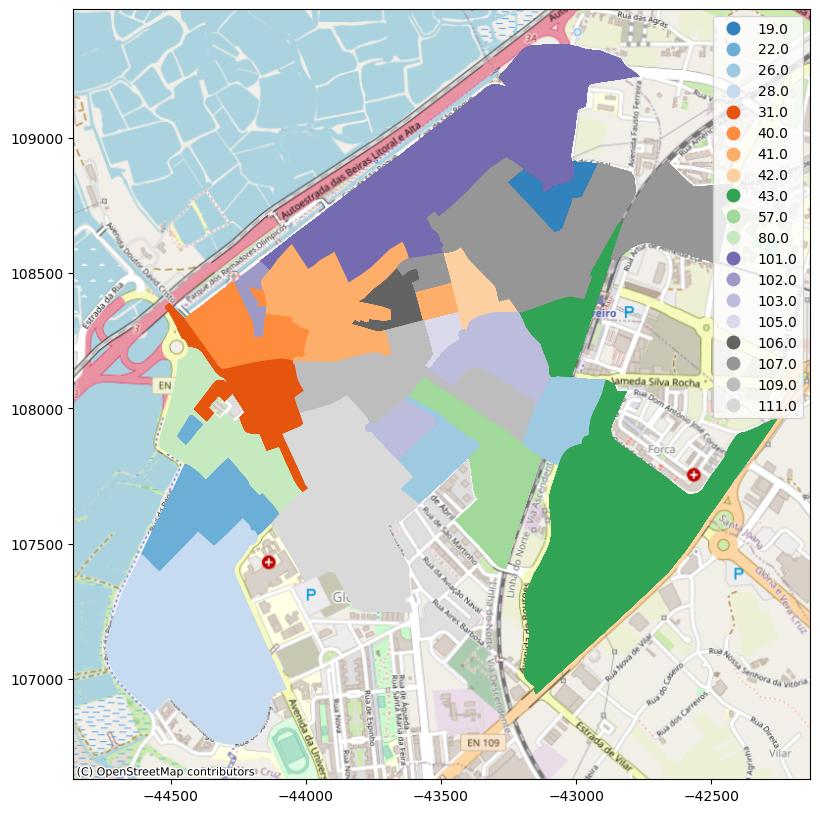

In [175]:
ax=data_aveiro.plot(column='Cluster_new',categorical=True, legend=True, figsize=(10,10), cmap='tab20c')
cx.add_basemap(ax,crs=data_aveiro.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [176]:
# copy data for the model (spatial reg)
spatial_reg=data_aveiro.copy()

In [177]:
spatial_reg.columns

Index(['Nature', 'Typology', 'Status', 'Price', 'Log_P_A', 'A', 'Year',
       'Cluster_new', 'NrUtentes', 'AL_pc', 'T', 'Log_AL', 'Log_Typ',
       'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen', 'Zona_Maxp',
       'Zona_SKATER', 'D', 'DT', 'IPI', 'Log_IPI'],
      dtype='object')

In [178]:
# get dummies for the spatial regression
spatial_reg = pd.get_dummies(spatial_reg, columns=['Status','Cluster_new'], drop_first=True, dtype=float)

In [179]:
spatial_reg.columns

Index(['Nature', 'Typology', 'Price', 'Log_P_A', 'A', 'Year', 'NrUtentes',
       'AL_pc', 'T', 'Log_AL', 'Log_Typ', 'geometry', 'area', 'Zona_Ward',
       'Zona_Ward_Queen', 'Zona_Maxp', 'Zona_SKATER', 'D', 'DT', 'IPI',
       'Log_IPI', 'Status_2.0', 'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Cluster_new_22.0', 'Cluster_new_26.0', 'Cluster_new_28.0',
       'Cluster_new_31.0', 'Cluster_new_40.0', 'Cluster_new_41.0',
       'Cluster_new_42.0', 'Cluster_new_43.0', 'Cluster_new_57.0',
       'Cluster_new_80.0', 'Cluster_new_101.0', 'Cluster_new_102.0',
       'Cluster_new_103.0', 'Cluster_new_105.0', 'Cluster_new_106.0',
       'Cluster_new_107.0', 'Cluster_new_109.0', 'Cluster_new_111.0'],
      dtype='object')

In [180]:
# Criação de dataframe com variável dependente, para uso nos modelos (NORTE)
Dep_Var = spatial_reg['Log_P_A'].astype(float)

# Criação de dataframe com variáveis independente, para uso nos modelos (NORTE)
Ind_Var = spatial_reg[['Log_AL',
       'Log_Typ', 'D', 'DT','T', 'Log_IPI', 'Status_2.0',
       'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Cluster_new_22.0', 'Cluster_new_26.0',
       'Cluster_new_28.0', 'Cluster_new_40.0',
       'Cluster_new_41.0', 'Cluster_new_42.0', 'Cluster_new_43.0',
       'Cluster_new_57.0', 'Cluster_new_80.0', 'Cluster_new_101.0',
       'Cluster_new_103.0', 'Cluster_new_105.0',
       'Cluster_new_107.0', 'Cluster_new_109.0',
       'Cluster_new_111.0']].astype(float)
# apenas 1 caso - 'Cluster_new_106.0','Cluster_new_102.0'
# removido Cluster_new_31.0, VIF muito alto

In [181]:
# calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = Ind_Var.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(Ind_Var.values, i)
                          for i in range(len(Ind_Var.columns))]

print(vif_data)

              feature        VIF
0              Log_AL  14.384651
1             Log_Typ  11.581043
2                   D  18.264836
3                  DT   7.512249
4                   T  17.114083
5             Log_IPI  26.475762
6          Status_2.0   1.823022
7          Status_3.0   2.113377
8          Status_4.0   1.470787
9          Status_5.0   2.408238
10   Cluster_new_22.0   1.095316
11   Cluster_new_26.0   1.961054
12   Cluster_new_28.0   1.120804
13   Cluster_new_40.0   2.996596
14   Cluster_new_41.0   1.554392
15   Cluster_new_42.0   1.285276
16   Cluster_new_43.0   1.502989
17   Cluster_new_57.0   1.773707
18   Cluster_new_80.0   1.098793
19  Cluster_new_101.0   2.442360
20  Cluster_new_103.0   2.583476
21  Cluster_new_105.0   1.470941
22  Cluster_new_107.0   2.692742
23  Cluster_new_109.0   1.702195
24  Cluster_new_111.0   1.112565


In [182]:
# Non-spatial Model (multiple regression)
M_OLS = spreg.OLS(
    Dep_Var.to_numpy(), # Dependent variable
    Ind_Var.to_numpy(), # Independent variable
    name_y = 'Log_P_A', # Dependent variable name
    name_x = list(Ind_Var.columns), #Independent variable name
    w = w_Queen,
    spat_diag=True,
    moran=True,
    name_ds='spatial_reg',
    name_w='w_Queen'
    )

print(M_OLS.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : spatial_reg
Weights matrix      :     w_Queen
Dependent Variable  :     Log_P_A                Number of Observations:        1752
Mean dependent var  :      7.2782                Number of Variables   :          26
S.D. dependent var  :      0.3660                Degrees of Freedom    :        1726
R-squared           :      0.5649
Adjusted R-squared  :      0.5586
Sum squared residual:     102.021                F-statistic           :     89.6478
Sigma-square        :       0.059                Prob(F-statistic)     :  7.784e-290
S.E. of regression  :       0.243                Log likelihood        :       4.783
Sigma-square ML     :       0.058                Akaike info criterion :      42.434
S.E of regression ML:      0.2413                Schwarz criterion     :     184.616

-----------------------------------------------------------------------------

LM error and LM Lag are non significant (0.61 and 0.17), hence we keep OLS as per Elhorst (2010).

## 4. (NOK) Linear Regressions (Ílhavo)

### 4.1 **(NOK)** Linear Regression (focused in Ílhavo Center - SKATER Cluster)

Poucos dados nesta região!!!

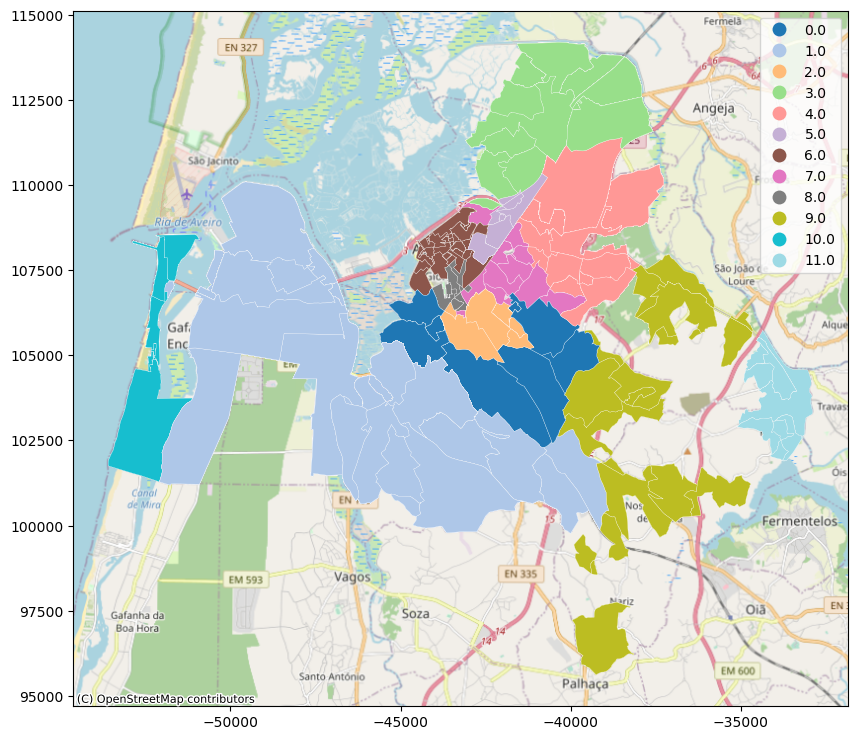

In [183]:
# check SKATER results
ax=plot_spatial_data.plot(figsize=(10, 10), column=plot_spatial_data["Zona_SKATER"], categorical=True, edgecolor="w", legend=True, linewidth=0.2,cmap='tab20')
cx.add_basemap(ax,crs=clusters.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [184]:
# define skater cluster for Ilhavo
data_ilhavo=spatial_data[spatial_data['Zona_SKATER']==1.0]

In [185]:
# transform to geodataframe
data_ilhavo=GeoDataFrame(data_ilhavo, geometry='geometry')

In [186]:
data_ilhavo.reset_index(drop=True, inplace=True)

In [187]:
data_ilhavo.head()

Nature  Typology  Status      Price   Log_P_A      A    Year  Cluster_new   
0     2.0       5.0     4.0  374000.00  6.840547  400.0  2008.0         48.0  \
1     1.0       3.0     1.0  167000.00  7.708261   75.0  2008.0         48.0   
2     2.0       5.0     4.0  174500.00  6.548219  250.0  2008.0          2.0   
3     1.0       3.0     3.0  107241.54  6.977669  100.0  2008.0         54.0   
4     2.0       5.0     2.0  225000.00  6.843217  240.0  2008.0         35.0   

   NrUtentes  AL_pc    T  Log_AL   Log_Typ   
0        0.0    0.0  0.0     0.0  1.609438  \
1        0.0    0.0  0.0     0.0  1.098612   
2        0.0    0.0  0.0     0.0  1.609438   
3        0.0    0.0  0.0     0.0  1.098612   
4        0.0    0.0  0.0     0.0  1.609438   

                                            geometry      area  Zona_Ward   
0  POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660        1.0  \
1  POLYGON ((-49390.576 107791.820, -49409.232 10...  2.742660        1.0   
2  POLYGON ((-41894.818 101023.152, -41985.704 10...  0.023841        4.0   
3  POLYGON ((-45337.609 103661.755, -45353.774 10...  0.013032        1.0   
4  POLYGON ((-40120.243 101443.753, -40179.897 10...  0.126959        3.0   

   Zona_Ward_Queen  Zona_Maxp  Zona_SKATER  
0              1.0        1.0          1.0  
1              1.0        1.0          1.0  
2              2.0        7.0          1.0  
3              1.0        1.0          1.0  
4              2.0        7.0          1.0

In [189]:
# no. of dwellings per cluster
pd.pivot_table(data_ilhavo, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))

Log_P_A
Cluster_new         
2.0               73
33.0              41
35.0              60
48.0             123
50.0             107
51.0             164
52.0              44
53.0              92
54.0             213
55.0              48
56.0              16
75.0              42
76.0               5
77.0              36
78.0               3
81.0              27
86.0              12
118.0             33
123.0              4
131.0             24

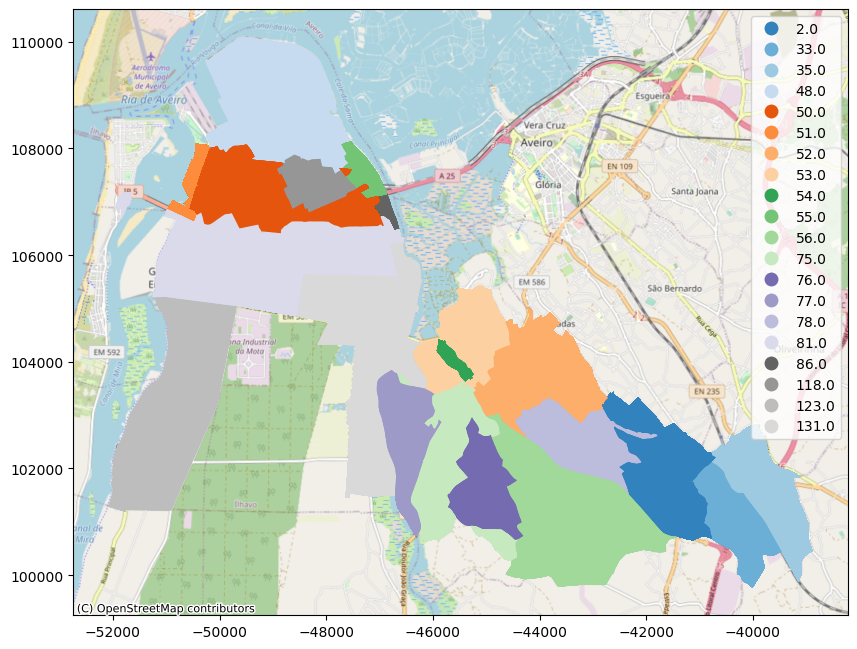

In [190]:
# check filter results
ax=data_ilhavo.plot(column=data_ilhavo['Cluster_new'],categorical=True, legend=True, figsize=(10,10), cmap='tab20c')
cx.add_basemap(ax,crs=data_ilhavo.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [191]:
# list of zones to be excluded from the analysis
lista_ilhavo_exclusao=[35,48,50,51,86,118,123,55,81]

In [192]:
# Area de Intervenção, a ser considerada D = 1
lista_ilhavo_D1=[75,77]

In [193]:
# apply filter
data_ilhavo=data_ilhavo[~data_ilhavo['Cluster_new'].isin(lista_ilhavo_exclusao)]

In [194]:
# write D column
data_ilhavo['D']=np.where(data_ilhavo['Cluster_new'].isin(lista_ilhavo_D1), 1, 0)

/Users/andresilvalima/opt/anaconda3/envs/BIC/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



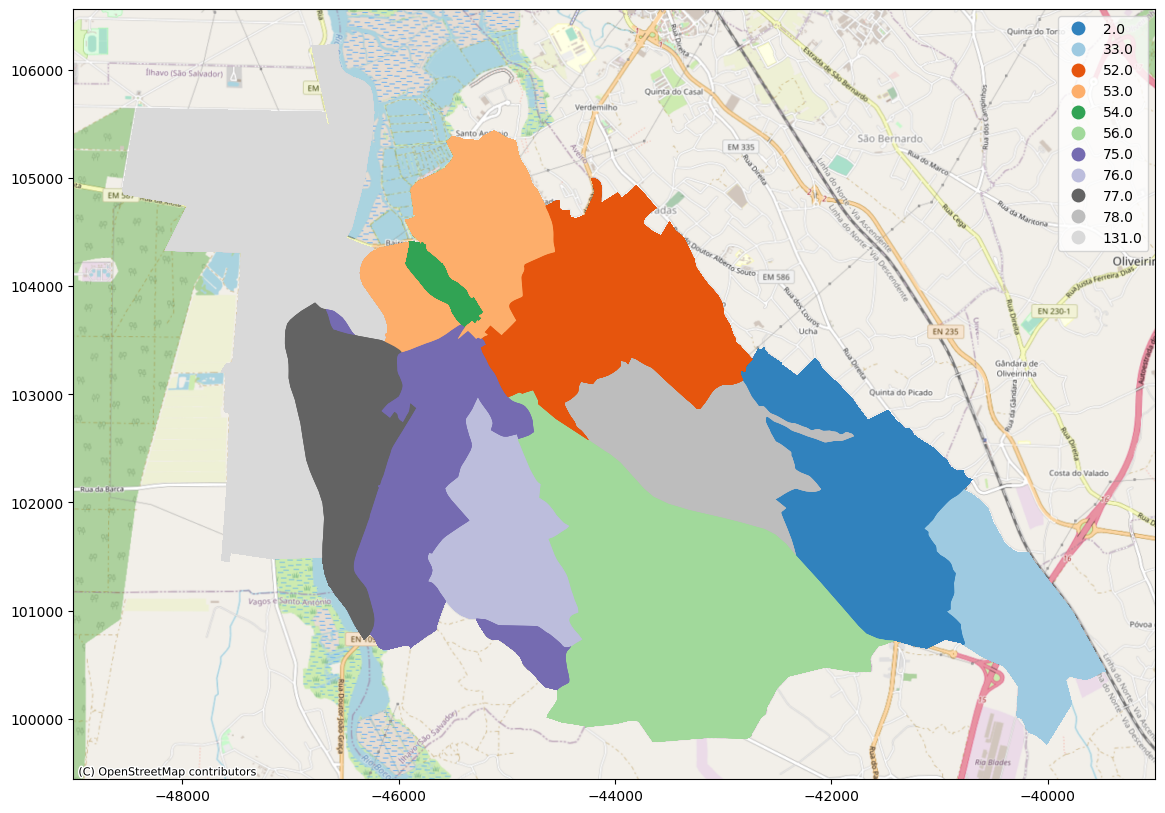

In [195]:
# check filtered clusters
ax=data_ilhavo.plot(column=data_ilhavo['Cluster_new'],categorical=True, legend=True, figsize=(20,10), cmap='tab20c')
cx.add_basemap(ax,crs=data_ilhavo.crs,source=cx.providers.OpenStreetMap.Mapnik)

In [196]:
data_ilhavo['D'].value_counts()

D
0    687
1     97
Name: count, dtype: int64

In [197]:
# get dummies
linreg_center_ilhavo = pd.get_dummies(data_ilhavo, columns=['Nature', 'Status', 'Year','Cluster_new'], drop_first=True)

In [198]:
linreg_center_ilhavo.reset_index(drop=True, inplace=True)

In [199]:
# calculate DT
linreg_center_ilhavo['DT']=linreg_center_ilhavo['D']*linreg_center_ilhavo['T']

In [200]:
# calculate log Typology
linreg_center_ilhavo['Log_Typ']=np.log(linreg_center_ilhavo['Typology'])

In [201]:
# number of dwellings per zone
pd.pivot_table(data_ilhavo, values='Log_P_A', index=['Cluster_new'], aggfunc=lambda x: len(x.unique()))

Log_P_A
Cluster_new         
2.0               73
33.0              41
52.0              44
53.0              92
54.0             213
56.0              16
75.0              42
76.0               5
77.0              36
78.0               3
131.0             24

In [202]:
linreg_center_ilhavo.columns

Index(['Typology', 'Price', 'Log_P_A', 'A', 'NrUtentes', 'AL_pc', 'T',
       'Log_AL', 'Log_Typ', 'geometry', 'area', 'Zona_Ward', 'Zona_Ward_Queen',
       'Zona_Maxp', 'Zona_SKATER', 'D', 'Nature_2.0', 'Status_2.0',
       'Status_3.0', 'Status_4.0', 'Status_5.0', 'Year_2006.0', 'Year_2007.0',
       'Year_2008.0', 'Year_2009.0', 'Year_2010.0', 'Year_2018.0',
       'Year_2019.0', 'Year_2020.0', 'Year_2021.0', 'Year_2022.0',
       'Year_2023.0', 'Cluster_new_33.0', 'Cluster_new_52.0',
       'Cluster_new_53.0', 'Cluster_new_54.0', 'Cluster_new_56.0',
       'Cluster_new_75.0', 'Cluster_new_76.0', 'Cluster_new_77.0',
       'Cluster_new_78.0', 'Cluster_new_131.0', 'DT'],
      dtype='object')

In [203]:
# define X and y
ilhavo_y_eur_area  = linreg_center_ilhavo['Log_P_A'].astype(float)

ilhavo_X_eur_area = linreg_center_ilhavo[['Log_Typ','DT','T','D','Log_AL',
       'Nature_2.0', 'Status_2.0', 'Status_3.0', 'Status_4.0', 'Status_5.0',
       'Year_2006.0', 'Year_2007.0', 'Year_2008.0', 'Year_2009.0',
       'Year_2010.0', 'Cluster_new_33.0',
       'Cluster_new_52.0', 'Cluster_new_53.0', 'Cluster_new_54.0',
       'Cluster_new_56.0', 'Cluster_new_76.0',
       'Cluster_new_78.0', 'Cluster_new_131.0']].astype(float)

# VIF inf removidos

In [204]:
# calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = ilhavo_X_eur_area.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(ilhavo_X_eur_area.values, i)
                          for i in range(len(ilhavo_X_eur_area.columns))]

print(vif_data)

              feature        VIF
0             Log_Typ  47.435479
1                  DT   3.043264
2                   T  20.582665
3                   D   3.321251
4              Log_AL   4.103425
5          Nature_2.0   5.162610
6          Status_2.0   2.680263
7          Status_3.0   3.330923
8          Status_4.0   2.583959
9          Status_5.0   2.502417
10        Year_2006.0   1.849258
11        Year_2007.0   6.730954
12        Year_2008.0   7.982425
13        Year_2009.0   6.144379
14        Year_2010.0  11.729115
15   Cluster_new_33.0   1.581315
16   Cluster_new_52.0   1.794800
17   Cluster_new_53.0   2.757347
18   Cluster_new_54.0   4.283058
19   Cluster_new_56.0   1.199648
20   Cluster_new_76.0   1.087619
21   Cluster_new_78.0   1.092253
22  Cluster_new_131.0   1.591880


In [205]:
# run the model
ilhavo_X_eur_area = sm.add_constant(ilhavo_X_eur_area)
model_ilhavo_eur_area = sm.OLS(ilhavo_y_eur_area, ilhavo_X_eur_area.astype(float))
results_ilhavo_eur_area = model_ilhavo_eur_area.fit()
results_ilhavo_eur_area.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.351   
Dependent Variable: Log_P_A          AIC:                391.0692
Date:               2023-05-22 11:42 BIC:                503.0150
No. Observations:   784              Log-Likelihood:     -171.53 
Df Model:           23               F-statistic:        19.44   
Df Residuals:       760              Prob (F-statistic): 1.60e-61
R-squared:          0.370            Scale:              0.093556
-----------------------------------------------------------------
                   Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-----------------------------------------------------------------
const              7.3428   0.1518 48.3652 0.0000  7.0448  7.6409
Log_Typ           -0.3987   0.0634 -6.2888 0.0000 -0.5231 -0.2742
DT                -0.0180   0.0779 -0.2304 0.8179 -0.1709  0.1350
T                  0.5094   0.1393  3.6576 0.0003  0.2360  0.7829
D                  0.0132   0.0571  0.2305 0.8177 -0.0989  0.1252
Log_AL            -1.4767   0.5332 -2.7696 0.0057 -2.5234 -0.4300
Nature_2.0         0.0434   0.0363  1.1969 0.2317 -0.0278  0.1146
Status_2.0        -0.0977   0.0389 -2.5151 0.0121 -0.1740 -0.0215
Status_3.0        -0.2446   0.0413 -5.9275 0.0000 -0.3256 -0.1636
Status_4.0        -0.3699   0.0499 -7.4088 0.0000 -0.4679 -0.2719
Status_5.0         0.1005   0.0359  2.7996 0.0052  0.0300  0.1709
Year_2006.0        0.1244   0.1496  0.8314 0.4060 -0.1693  0.4180
Year_2007.0        0.0765   0.1316  0.5812 0.5613 -0.1818  0.3348
Year_2008.0        0.0225   0.1295  0.1739 0.8620 -0.2317  0.2768
Year_2009.0        0.0359   0.1317  0.2722 0.7855 -0.2227  0.2945
Year_2010.0        0.0875   0.1298  0.6743 0.5003 -0.1673  0.3424
Cluster_new_33.0  -0.2184   0.0469 -4.6550 0.0000 -0.3105 -0.1263
Cluster_new_52.0   0.0508   0.0543  0.9358 0.3497 -0.0558  0.1574
Cluster_new_53.0   0.1339   0.0494  2.7096 0.0069  0.0369  0.2309
Cluster_new_54.0   0.0480   0.0394  1.2183 0.2235 -0.0294  0.1255
Cluster_new_56.0  -0.0041   0.0716 -0.0575 0.9542 -0.1447  0.1365
Cluster_new_76.0   0.1993   0.1427  1.3962 0.1631 -0.0809  0.4795
Cluster_new_78.0   0.1434   0.1847  0.7767 0.4376 -0.2191  0.5059
Cluster_new_131.0 -0.0910   0.0788 -1.1551 0.2484 -0.2456  0.0637
-----------------------------------------------------------------
Omnibus:             131.713      Durbin-Watson:         1.966   
Prob(Omnibus):       0.000        Jarque-Bera (JB):      2131.826
Skew:                0.071        Prob(JB):              0.000   
Kurtosis:            11.077       Condition No.:         96      
=================================================================
Notes:
[1] Standard Errors assume that the covariance matrix of the
errors is correctly specified.
"""

Temos muito poucos casos para D=1 (97 casos) e D=0 (687 casos). Tendo em conta a heterogenidade de casas (diferentes estados de preservação, tipologia, etc.), 97 casos não é suficiente para fazer uma análise estatística robusta.